# ORCS intermediate

In [1]:
import pylab as pl
import numpy as np

import orcs.process
import orb.utils.io # utility library to write and read files

## Loading your cube

In [2]:
cube = orcs.process.SpectralCube('/home/thomas/data/M31/M31_SN3/M31_SN3.merged.cm1.1.0.hdf5')

INFO| Data shape : (2048, 2064, 840)
INFO| Cube is in WAVENUMBER (cm-1)
INFO| Cube is CALIBRATED in wavenumber


## Extracting data from an irregular region

There are different methods for data extraction:
### circular aperture

`cube.extract_spectrum(x, y, r)`

* x, y: pixel position of the **center** (in pixels)
* r: radius (in pixels)

### squared aperture (binning)

`cube.extract_spectrum_bin(x, y, b)`

* x, y: pixel position of the **bottom-left corner** (in pixels)
* b: binning or square size (in pixels)

### irregular region

`cube.extract_integrated_spectrum(region)`

* region: can be a list of pixels or a **ds9 region file path**

The deep frame can be downloaded with JupyterLab easily. A region can be created and saved in a ds9 region file. You can choose to save it with image coordinates or celestial coordinates (fk5). I did both for a circular aperture around (919, 893) and obtained:

warning : **ds9 pixels starts at 1, i.e. : the object at 919, 893 in the spectral cube is at 920, 894 in ds9**

* `ds9-pix.reg`
```bash
# Region file format: DS9 version 4.1
global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
image
circle(920,894,2)
```

* `ds9-fk5.reg`
```bash
# Region file format: DS9 version 4.1
global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
fk5
circle(0:42:48.9232,+41:15:24.000,0.647")
```

These files can be uploaded to your session with
```bash
scp -p 443 ds9-pix.reg login@celeste.phy.ulaval.ca:~/
```

In [4]:
# we can define a mask
pix_list = cube.get_mask_from_ds9_region_file('data/ds9-pix.reg')
mask = np.zeros((cube.dimx, cube.dimy), dtype=int)
mask[pix_list] = 1
orb.utils.io.write_fits('mask.fits',mask, overwrite=True)
mask = orb.utils.io.read_fits('mask.fits')
pix_list = np.nonzero(mask)

 loading region: Shape : circle ( Number(920),Number(894),Number(2) )



INFO| Data written as mask.fits in 1.04 s 


WARNING| /home/thomas/miniconda2/envs/orb/lib/python2.7/site-packages/astropy/wcs/wcs.py:2566: AstropyWarning: Some non-standard WCS keywords were excluded: BP_0_0, BP_0_1, BP_0_2, A_3_0, B_3_0, BP_3_0, B_1_2, B_1_0, B_1_1, B_2_1, B_2_0, A_ORDER, B_0_3, B_0_2, B_0_1, B_0_0, BP_0_3, B_ORDER, BP_ORDER, BP_1_2, AP_ORDER, AP_3_0, A_1_1, A_1_0, BP_2_0, A_1_2, AP_2_1, AP_2_0, A_0_0, A_0_1, A_0_2, A_0_3, BP_1_1, BP_1_0, A_2_0, A_2_1, AP_1_0, AP_1_1, AP_1_2, BP_2_1, AP_0_1, AP_0_0, AP_0_3, AP_0_2 Use the ``relax`` kwarg to control this.
  AstropyWarning)



 loading region: Shape : circle ( HMS(0:42:48.9232),DMS(+41:15:24.000),Ang(0.647") )



INFO| Number of integrated pixels: 11


 [==========] [100%] [completed in 0.077 s]
 [==========] [100%] [completed in 0.052 s]
 loading region: Shape : circle ( Number(920),Number(894),Number(2) )

INFO| Number of integrated pixels: 13




 [==========] [100%] [completed in 0.178 s]
 [==========] [100%] [completed in 0.073 s]


INFO| Number of integrated pixels: 13


 [==========] [100%] [completed in 0.033 s]
 [==========] [100%] [completed in 0.086 s]

INFO| Number of integrated pixels: 13



 [==========] [100%] [completed in 0.034 s]
 [==========] [100%] [completed in 0.084 s]


Text(0.5,1,'spectrum extracted using different definitions: note the differences between ds9 fk5 and pix coordinates')

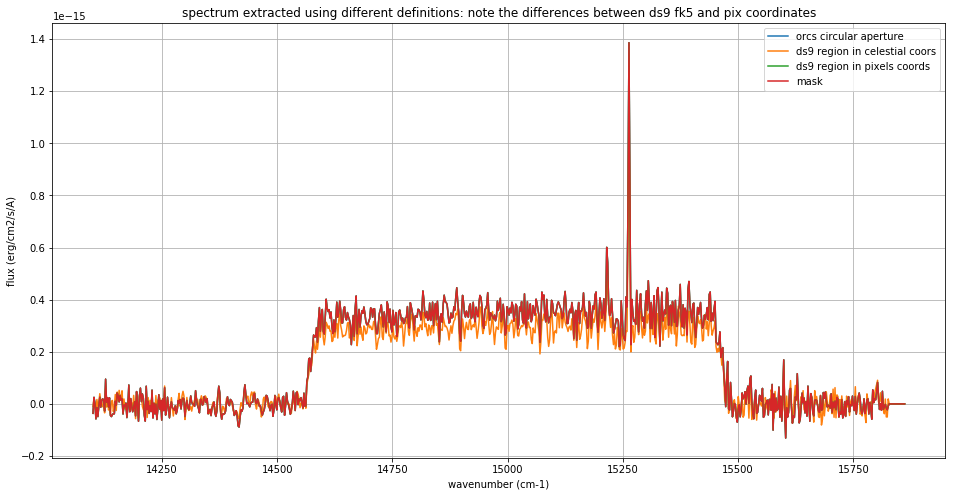

In [5]:
# here we extract the integrated spectrum from a region defined with ds9 in pixels
axis, spectrum_fk5 = cube.extract_integrated_spectrum('data/ds9-fk5.reg')
axis, spectrum_pix = cube.extract_integrated_spectrum('data/ds9-pix.reg')
axis, spectrum = cube.extract_spectrum(919, 893, 2)
axis, spectrum_mask = cube.extract_integrated_spectrum(pix_list)


pl.figure(figsize=(16, 8))
pl.plot(axis, spectrum, label='orcs circular aperture')
pl.plot(axis, spectrum_fk5, label='ds9 region in celestial coors')
pl.plot(axis, spectrum_pix, label='ds9 region in pixels coords')
pl.plot(axis, spectrum_mask, label='mask')
pl.legend()
pl.xlabel('wavenumber (cm-1)')
pl.ylabel('flux (erg/cm2/s/A)')
pl.grid()
pl.title('spectrum extracted using different definitions: note the differences between ds9 fk5 and pix coordinates')

## Measuring the velocity of the lines

Initial velocity must be known with enough precision for the fit to work. It is easy to check quickly where the initial lines will fall.

INFO| Number of integrated pixels: 13


 [==========] [100%] [completed in 0.049 s]
 [==========] [100%] [completed in 0.081 s]


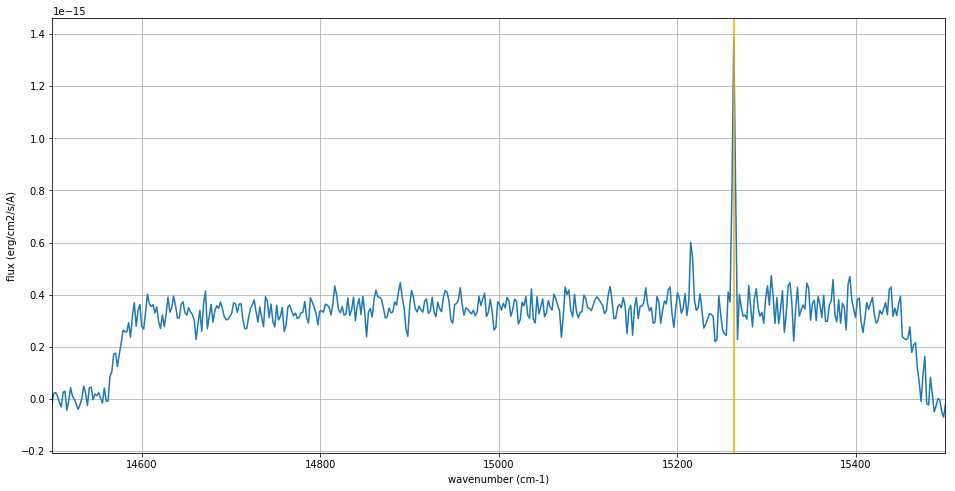

In [23]:
axis, spectrum = cube.extract_spectrum(919, 893, 2)

ha_cm1 = orb.core.Lines().get_line_cm1('Halpha')
ha_cm1 += orb.utils.spectrum.line_shift(-513, ha_cm1, wavenumber=True)

pl.figure(figsize=(16, 8))
pl.plot(axis, spectrum)

pl.axvline(ha_cm1, color='orange')

pl.xlabel('wavenumber (cm-1)')
pl.ylabel('flux (erg/cm2/s/A)')
pl.xlim((14500, 15500))
pl.grid()

## Fitting a spectrum

A lot of information on the different parameters of the fitting function can be found here: http://celeste.phy.ulaval.ca/orcs-doc/introduction.html

When a spectrum is fitted, it is **extracted and fitted**, so that the **extraction methods are all available with the fitting methods**:

### circular aperture

`cube.fit_lines_in_spectrum(x, y, r, *fit_parameters)`

* x, y: pixel position of the **center** (in pixels)
* r: radius (in pixels)

### squared aperture (binning)

`cube.fit_lines_in_spectrum_bin(x, y, b, *fit_parameters)`

* x, y: pixel position of the **bottom-left corner** (in pixels)
* b: binning or square size (in pixels)

### irregular region

`cube.fit_lines_in_integrated_region(region, *fit_parameters)`

* region: can be a list of pixels or a **ds9 region file path**

## emission line models

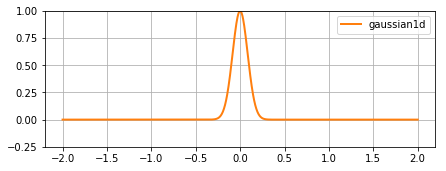

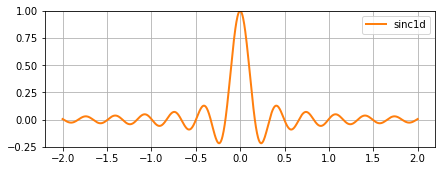

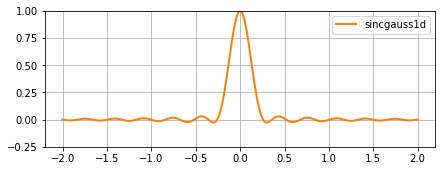

In [37]:
def plot(f, *p):
    name = str(f).split()[1]
    pl.figure(figsize=(7,2.5))
    y = f(*p)
    pl.plot(p[0], y, label=name, c='#ff7f0e', lw=2)
    pl.grid()
    pl.legend()
    pl.ylim(np.array([-0.25,1]) * np.max(y))
    pl.savefig('{}.svg'.format(name))
    
x = np.linspace(-2,2,1000)
h = 0
a = 1
dx = 0
fwhm = 0.2
sigma = 0.1
alpha = 0.2

plot(orb.utils.spectrum.gaussian1d, x, h, a, dx, fwhm)
plot(orb.utils.spectrum.sinc1d, x, h, a, dx, fwhm)
plot(orb.utils.spectrum.sincgauss1d, x, h, a, dx, fwhm, sigma)

## emission lines parameters
![elp](images/emission-line-params.png)

The line fitting model can be controlled precisely with ORCS. A complete explanation can be found here : http://celeste.phy.ulaval.ca/orcs-doc/introduction.html

A `sinc` emission line has 3 parameters:

* amplitude: `amp`
* velocity:`pos`
* fwhm: `fwhm`

Each fitting parameter can be controlled via its:

* definition: `_def`
* input value: `_guess`
* covarying input values: `_cov`

the possible keywords are then:

* `amp_def`
* `amp_guess`
* `amp_cov`
* `pos_def`
* `pos_guess`
* `pos_cov`
* ...

### parameters definition

Each parameter can be set to :

* `'fixed'`
* `'free'`
* **labeled**: e.g. `'1'` (the number has no importance as long as it is the same for each group of lines)

If we have three emission lines`['Halpha', '[NII]6548', '[NII]6584']`, the definition of the velocity can be e.g.:

* `'pos_def'=('free', '1', '1')`: Halpha velocity is 'free', both NII lines share the same velocity.
* `'fwhm_def'='fixed'`: All lines have a fixed fwhm (default)
* `'pos_def'='2'`: All lines have the same velocity

Note that all lines can have the same fwhm but different velocities.



### covarying parameters

![covar](images/covar.jpg)

the same line parameter can be set to be covarying between different lines. It means that a given set of lines have the same velocity, or the same fwhm, or a given amplitude ratio (not the same amplitude). 

The input value of the parameter will thus be fixed and only the covarying value will change. e.g.:

`'amp_def' = ('free', '1', '1')` : NII lines have a caovarying amplitude
`'amp_guess' = (1, 1, 3)`: the initial ratio of the NII lines is 3 to 1 (the initial guess in the amplitude of both lines will be kept but will then be multiplied by the same amplitude parameter)
`'amp_cov' = 1e-18`: only one value because there is only one group of lines (the group labeled '1'). The initial value of the amplitude of the NII lines will be : 1e-18 and 3e-18. Onky the covariant parameter will change during the fit.



### First pass with sinc model and naive amplitude constraint

INFO| Number of integrated pixels: 13


 [==========] [100%] [completed in 0.037 s]
 [==========] [100%] [completed in 0.085 s]

===== Results ======
Velocity:  [-507.8(1.3) -507.8(1.3) -507.8(1.3)]
Flux:  [1.679(87)e-15 3.89(56)e-16 1.30(19)e-16]


(14500, 15500)

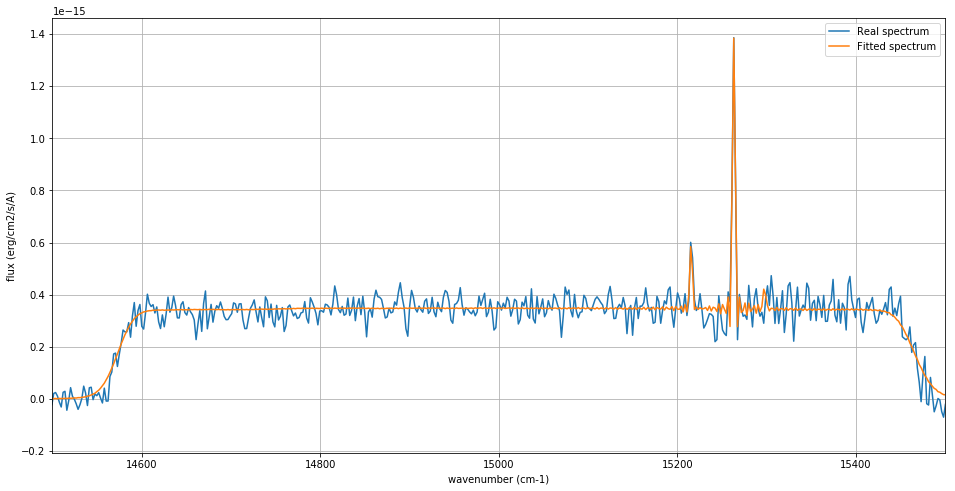

In [29]:
axis, spectrum, fit_res = cube.fit_lines_in_spectrum(919, 893, 2, 
                                                     ['Halpha', '[NII]6583', '[NII]6548'], # emission lines
                                                     fmodel='sinc', # line model
                                                     pos_cov=-513, # input velocity in km/s
                                                     pos_def=['1', '1', '1'], # both lines share the same velocity
                                                     amp_def=['1', '2', '2'],
                                                     amp_guess=[1, 3, 1])
print '\n===== Results ======'
print 'Velocity: ', fit_res['velocity_gvar']
print 'Flux: ', fit_res['flux_gvar']
print '===================='

pl.figure(figsize=(16, 8))
pl.plot(axis, spectrum, label='Real spectrum')
pl.plot(axis, fit_res['fitted_vector'], label='Fitted spectrum')
pl.legend()
pl.grid()
pl.xlabel('wavenumber (cm-1)')
pl.ylabel('flux (erg/cm2/s/A)')
pl.xlim((14500, 15500))

INFO| Number of integrated pixels: 13


 [==========] [100%] [completed in 0.037 s]
 [==========] [100%] [completed in 0.085 s]

===== Results ======
Velocity:  [-507.8(1.3) -507.8(1.3) -507.8(1.3)]
Flux:  [1.679(87)e-15 3.89(56)e-16 1.30(19)e-16]


(14500, 15500)

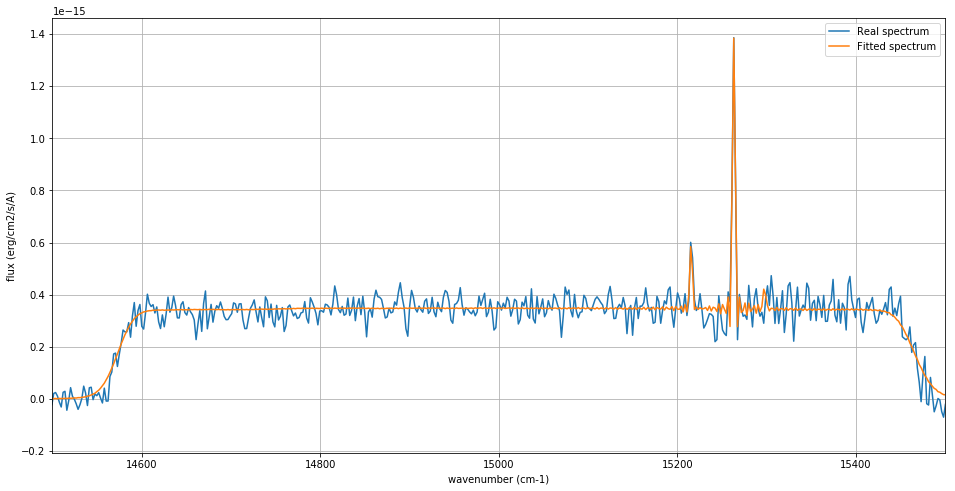

In [29]:
amp_ratio = cube.get_amp_ratio_from_flux_ratio('[NII]6583', '[NII]6548', 3)
axis, spectrum, fit_res = cube.fit_lines_in_spectrum(919, 893, 2, 
                                                     ['Halpha', '[NII]6583', '[NII]6548'], # emission lines
                                                     fmodel='sincgauss', # line model
                                                     sigma_def=['1', '1', '1'],
                                                     sigma_guess=20,
                                                     pos_cov=-513, # input velocity in km/s
                                                     pos_def=['1', '1', '1'], # both lines share the same velocity
                                                     amp_def=['1', '2', '2'],
                                                     amp_guess=[1, amp_ratio, 1])
print '\n===== Results ======'
print 'Velocity: ', fit_res['velocity_gvar']
print 'Flux: ', fit_res['flux_gvar']
print '===================='

pl.figure(figsize=(16, 8))
pl.plot(axis, spectrum, label='Real spectrum')
pl.plot(axis, fit_res['fitted_vector'], label='Fitted spectrum')
pl.legend()
pl.grid()
pl.xlabel('wavenumber (cm-1)')
pl.ylabel('flux (erg/cm2/s/A)')
pl.xlim((14500, 15500))

## Fit outputs

The output of a fit is a dict. We describe here the most important.

### calculated parameters Flux and Velocity : 'velocity', 'velocity_err', 'velocity_gvar', 'flux', 'flux_err', 'flux_gvar'

Velocity is, in fact, one of the fitted parameters and the final line wavenumber os computed from its initial wavenumber and its measured velocity. Flux is computed from the fwhm and the amplitude, in general, dependaning on the model (here a `sinc`).


In [31]:
print 'velocity of the lines : {} km/s'.format(fit_res['velocity_gvar'])
print 'flux of the lines : {} erg/cm2/s'.format(fit_res['flux_gvar'])
print 'checking ratio 6584/6548 : {} erg/cm2/s'.format(fit_res['flux_gvar'][1]/fit_res['flux_gvar'][2])


velocity of the lines : [-507.8(1.3) -507.8(1.3) -507.8(1.3)] km/s
flux of the lines : [1.679(87)e-15 3.89(56)e-16 1.30(19)e-16] erg/cm2/s
checking ratio 6584/6548 : 2.99(61) erg/cm2/s


### fit parameters: 'fit_params', 'fit_params_err', 'fit_params_gvar'

fit parameters are stored as estimation (`'fit_params'`) and uncertainty on the estimation (`'fit_params_err'`) or directly as gaussian variables`gvar` (`'fit_params_gvar'`).
for more info on `gvar` see [Gvar](../basics/basics_gvar).

Note that all the fit parameters are displayed: the continuum and the filter shift also (when the filter is fitted, it must be shifted because its passband changes with the incident angle, i.e. with the position in the field)

In [24]:
print fit_res['fit_params_gvar']
print '---------------'
print 'amplitude of the first line: {} erg/cm2/s/A'.format(fit_res['fit_params_gvar'][0]['amp0'])
print 'fwhm of the first line: {} cm-1'.format(fit_res['fit_params_gvar'][0]['fwhm0'])
print 'wavenumber of the first line: {} cm-1'.format(fit_res['fit_params_gvar'][0]['pos0'])


[{'sigma2': 25.8(1.6), 'fwhm1': array(3.15772682), 'sigma1': 25.8(1.6), 'sigma0': 25.8(1.6), 'pos1': 15215.352(66), 'amp2': 8.2(1.1)e-17, 'amp0': 1.051(37)e-15, 'amp1': 2.43(34)e-16, 'pos2': 15297.609(67), 'fwhm0': array(3.15772682), 'pos0': 15263.184(66), 'fwhm2': array(3.15772682)}, {'cont_p0': 3.510(21)e-16}, {'filter_shift': 3.00(45)}]
---------------
amplitude of the first line: 1.051(37)e-15 erg/cm2/s/A
fwhm of the first line: 3.15772681924 cm-1
wavenumber of the first line: 15263.184(66) cm-1


## Working with WCS

Convert pixel positions to celestial coordinates. This is useful when comparing spectra from two different data cubes (e.g. same object but different filters)

In [12]:
print 'x:919, y:893 in celestial coordinates (degrees): ', cube.pix2world([919, 893]) # in degrees
print 'x:919, y:893 in celestial coordinates (HMS, DMS): \n', cube.pix2world([919, 893], deg=False) # in hms, dms
print 'pixel coordinates of the object at ra:10.70384676 dec:41.25666675', cube.world2pix([10.70384676, 41.25666675])


x:919, y:893 in celestial coordinates (degrees):  [[10.70386314 41.25666259]]
x:919, y:893 in celestial coordinates (HMS, DMS): 
[[ 0.         42.         48.92715284]
 [41.         15.         23.98531982]]
pixel coordinates of the object at ra:10.70384676 dec:41.25666675 [[919.13526271 893.04909115]]
